In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from glob import glob
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint
import tarfile
from tqdm import tqdm_notebook

# Klotz, Jerome H. "UPDATING SIMPLE LINEAR REGRESSION."
# Statistica Sinica 5, no. 1 (1995): 399-403.
# http://www.jstor.org/stable/24305577
def online_simple_regression(accumulator, x, y):
    Ax_, Ay_, Sxy, Sxx, n_, miny, maxy = accumulator or (0, 0, 0, 0, 0, 0, 0)

    first = n_ == 0
    n = n_ + x.size
    rt_n, rt_n_ = np.sqrt((n, n_), dtype=np.float128)

    Ax = (Ax_*n_ + x.sum(dtype=np.float128))/n
    Ay = (Ay_*n_ + y.sum(dtype=np.float128))/n
    
    miny = min(miny, y.min())
    maxy = max(maxy, y.max())
    
    X = Ax if first else (Ax_*rt_n_ + Ax*rt_n)/(rt_n_ + rt_n)
    Y = Ay if first else (Ay_*rt_n_ + Ay*rt_n)/(rt_n_ + rt_n)

    Sxx += np.sum((x - X)**2)
    Sxy += np.sum((x - X)*(y - Y))

    return Ax, Ay, Sxy, Sxx, n, miny, maxy

def conv_px(s):
    w, h = s.split(b'x')
    return int(w)*int(h)

conv_fti = [b'I', b'P', b'B0', b'B1'].index

def collect(filename, queues):
    px, log_target_q, byte_size, frame_type = np.loadtxt(
        filename, dtype=np.int64, delimiter=',',
        converters={1: conv_px, 4: conv_fti},
        skiprows=1, usecols=range(1, 5), unpack=True)

    blog64q57_ibpp = np.round((
        np.log2(px, dtype=np.float128) - np.log2(byte_size*8, dtype=np.float128)
    )*2**57).astype(np.int64)

    for fti in np.unique(frame_type):
        x, y = log_target_q[frame_type==fti], blog64q57_ibpp[frame_type==fti]
        queue = queues.get(fti, ([], []))
        queue[0].append(x)
        queue[1].append(y)
        queues[fti] = queue

def aggregate(queues, partials):
    for fti, queue in queues.items():
        x, y = np.concatenate(queue[0]), np.concatenate(queue[1])
        partials[fti] = online_simple_regression(partials.get(fti, None), x, y)
    queues.clear()

partials = dict()
# https://ba.rr-dav.id.au/data/rav1e/rc-data.tar.xz
with tarfile.open('rc-data.tar.xz', 'r:xz') as tf:
    queues, last_name = dict(), None
    for ti in tqdm_notebook(tf, total=1077*255, leave=False):
        name = ti.name.split('/')[0]
        if last_name and name != last_name:
            aggregate(queues, partials)
        last_name = name
        collect(tf.extractfile(ti), queues)
    aggregate(queues, partials)
pprint(partials)

{0: (5.938885278876450718e+17,
     1.9137710889304368723e+17,
     2.410941997325506283e+40,
     2.4723415216574388483e+40,
     337110,
     -479784840691660528,
     1428504883828996212),
 1: (6.505176872133070449e+17,
     5.7400758576573096778e+17,
     2.9449582682435935951e+41,
     1.9503819765026800224e+41,
     2659395,
     -430456311176036496,
     2134890862486819534),
 2: (7.071468465389690206e+17,
     8.0193697664877629525e+17,
     2.9225410017825442604e+41,
     1.9821745679309526856e+41,
     2702745,
     -392114462299251034,
     1791224583212461071),
 3: (7.637760058646309966e+17,
     9.827995667253292844e+17,
     5.475769590533601731e+41,
     3.9548113584334235726e+41,
     5392485,
     -369660646353102446,
     1993683613661377668)}


 I: exp=62 scale=52
 P: exp=97 scale=57
B0: exp=94 scale=25
B1: exp=89 scale=11


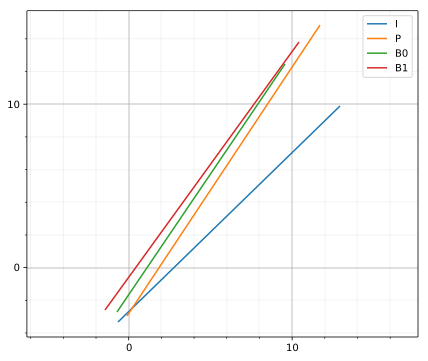

In [2]:
plt.figure(figsize=(7, 6))
plt.axis('equal')
plt.xticks([0, 10])
plt.yticks([0, 10])
plt.minorticks_on()
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor', alpha=0.2)

for fti, accumulator in partials.items():
    Ax, Ay, Sxy, Sxx, n, miny, maxy = accumulator

    beta = Sxy/Sxx
    alpha = Ay - beta*Ax
    scale = int(np.round(np.exp2(3 - alpha/2**57)))
    exp = int(np.round(beta*2**6))
    label = ['I', 'P', 'B0', 'B1'][fti]
    print('%2s: exp=%d scale=%d' % (label, exp, scale))

    ys = [miny/2**57, maxy/2**57]
    xs = [(ys[0] - alpha/2**57)/beta, (ys[1] - alpha/2**57)/beta]
    plt.plot(xs, ys, label=label)

plt.legend();